# CNN-Challenge-A: particle image classifier

# Example analysis

This notebook shows an example of analyzing a network. We use the trained weights (parameters) of a CNN model called ResNet.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
torch.multiprocessing.set_start_method('spawn')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

## Dataloader

We will use the model trained for the first half (50%) of the train dataset. Let's try validation on the second half of the train dataset.

In [2]:
from cnn_challenge_a import ParticleImage2D
datapath='/sdf/group/neutrino/kterao/data/kmi2020/image_classification/train.h5'

val_data = ParticleImage2D(data_files = [datapath],
                           start = 0.5, # start of the dataset fraction to use. 0.0 = use from 1st entry
                           end   = 1.0, # end of the dataset fraction to use. 1.0 = use up the last entry
                          )

# We use a specifically designed "collate" function to create a batch data
from cnn_challenge_a import collate
from torch.utils.data import DataLoader
val_loader = DataLoader(val_data,
                        collate_fn  = collate,
                        shuffle     = True,
                        num_workers = 4,
                        batch_size  = 64
                       )


## Analysis

Let's construct a network. Below code is a copy & paste from an example

In [4]:
from resnet import ResNet

class BLOB:
    pass
blob=BLOB()
blob.device    = device # GPU or CPU
blob.net       = ResNet(10,1,16,[2,2,2,2,2]).to(blob.device) # construct the network, set to the right device
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.iteration = 0    # integer count for the number of train steps
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis


Let's also list the weight files from training.

In [21]:
import glob
weight_files = glob.glob('weights_a/ResNet-*.ckpt')
weight_steps = [int(f.split('-')[-1].rstrip('.ckpt')) for f in weight_files]
weight_steps.sort()
print('Weights stored:\n',weight_steps)

Weights stored:
 [0, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000]




Next, let's loop over the weight files and compute the model accuracy on the validation set.

In [37]:
# Import train_loop, plot_loss
from utils import inference_loop, plot_loss, restore_state

def loop_validation(blob,num_iterations=800):
    
    file_prefix = '/sdf/group/neutrino/kterao/data/kmi2020/image_classification/weights/ResNet'
    
    import glob, os
    weight_files = glob.glob(file_prefix + '*')
    weight_steps = [int(f.split('-')[-1].rstrip('.ckpt')) for f in weight_files]
    weight_steps.sort()

    accuracy_history = [[],[],[]]
    for step in weight_steps:
        blob.weight_file = file_prefix + '-%d.ckpt' % step
        
        restore_state(blob)

        results = inference_loop(blob,
                                 val_loader,
                                 num_iterations=num_iterations)
        
        accuracy,labels,prediction,softmax = results

        print('Processing iteration',step)
        
        accuracy_history[0].append(step)
        accuracy_history[1].append(accuracy.mean())
        accuracy_history[2].append(accuracy.std())
            
    return np.array(accuracy_history)

OK let's run the validation loop and store the accuracy mean and std per step in a file.

In [39]:
import os

# !!! This cell takes time to execute !!!
#
# You can find val_accuracy_a.npz under:
#  - /sdf/group/neutrino/kterao/data/kmi2020/image_classification/weights/
#
# If analyzing your own weights, please run the loop.
#

if not os.path.isfile('val_accuracy_a.npz'):

    results = loop_validation(blob)

    np.savez('val_accuracy_a.npz',
             iteration=results[0],
             mean=results[1],
             std=results[2])

Processing iteration 0
Processing iteration 20
Processing iteration 30
Processing iteration 40
Processing iteration 50
Processing iteration 60
Processing iteration 70
Processing iteration 80
Processing iteration 90
Processing iteration 100
Processing iteration 200
Processing iteration 300
Processing iteration 400
Processing iteration 500
Processing iteration 600
Processing iteration 700
Processing iteration 800
Processing iteration 900
Processing iteration 1000
Processing iteration 2000
Processing iteration 3000
Processing iteration 4000
Processing iteration 5000
Processing iteration 6000
Processing iteration 7000
Processing iteration 8000
Processing iteration 9000
Processing iteration 10000
Processing iteration 20000
Processing iteration 30000
Processing iteration 40000
Processing iteration 50000
Processing iteration 60000
Processing iteration 70000
Processing iteration 80000
Processing iteration 90000



Validation accuracy...

Final accuracy mean 0.9566 std 0.0249

Best  accuracy mean 0.9618 std 0.0245



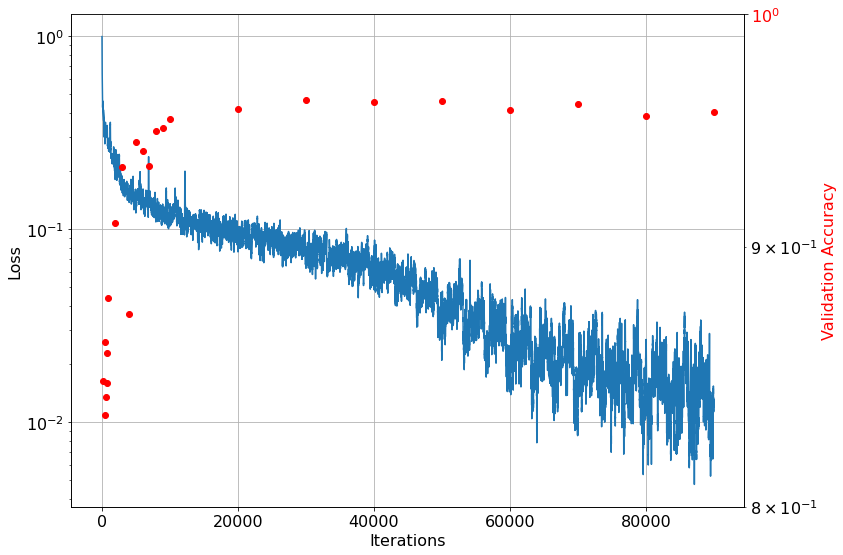

In [51]:
from utils import moving_average

val=np.load('val_accuracy_a.npz')
train=np.load('train_log_a.npz')

best_step = np.argmax(val['mean'])
print('\nValidation accuracy...')
print('\nFinal accuracy mean %.4f std %.4f' % (val['mean'][-1],val['std'][-1]))
print('\nBest  accuracy mean %.4f std %.4f' % (val['mean'][best_step],val['std'][best_step]))
print()
# Plot them together

fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_yscale('log')
ax.plot(*moving_average(train['loss'],50))

aax = ax.twinx()
aax.tick_params(axis='y', labelcolor='red')
aax.set_ylabel('Validation Accuracy',color='red')
aax.set_yscale('log')
aax.set_ylim(0.8,1.0)
aax.plot(val['iteration'],val['mean'],color='red',marker='o',linestyle='')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
